In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,StandardScaler,MinMaxScaler,PowerTransformer,FunctionTransformer
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression,RidgeClassifier,LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix


In [2]:
import cufflinks as cf
import plotly.offline
import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

In [3]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [4]:
#load the dataset
df=pd.read_csv("/Users/g.s.rajsankar/Downloads/heart_failure.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
df.shape

(918, 12)

In [6]:
print(f"number of rows:--> {df.shape[0]} and number of columns:--> {df.shape[1]}")

number of rows:--> 918 and number of columns:--> 12


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [8]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [9]:
df.duplicated().sum()

0

In [10]:
#check data description
df.describe().T.style.bar(subset=['mean'], color='#205ff2').background_gradient(subset=['std'], cmap='Reds').background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Age,918.000000,53.510893,9.432617,28.000000,47.000000,54.000000,60.000000,77.000000
RestingBP,918.000000,132.396514,18.514154,0.000000,120.000000,130.000000,140.000000,200.000000
Cholesterol,918.000000,198.799564,109.384145,0.000000,173.250000,223.000000,267.000000,603.000000
FastingBS,918.000000,0.233115,0.423046,0.000000,0.000000,0.000000,0.000000,1.000000
MaxHR,918.000000,136.809368,25.460334,60.000000,120.000000,138.000000,156.000000,202.000000
Oldpeak,918.000000,0.887364,1.066570,-2.600000,0.000000,0.600000,1.500000,6.200000
HeartDisease,918.000000,0.553377,0.497414,0.000000,0.000000,1.000000,1.000000,1.000000


In [11]:
#check the correlation between terget and each of columns
df.corr()["HeartDisease"]

Age             0.282039
RestingBP       0.107589
Cholesterol    -0.232741
FastingBS       0.267291
MaxHR          -0.400421
Oldpeak         0.403951
HeartDisease    1.000000
Name: HeartDisease, dtype: float64

<AxesSubplot:>

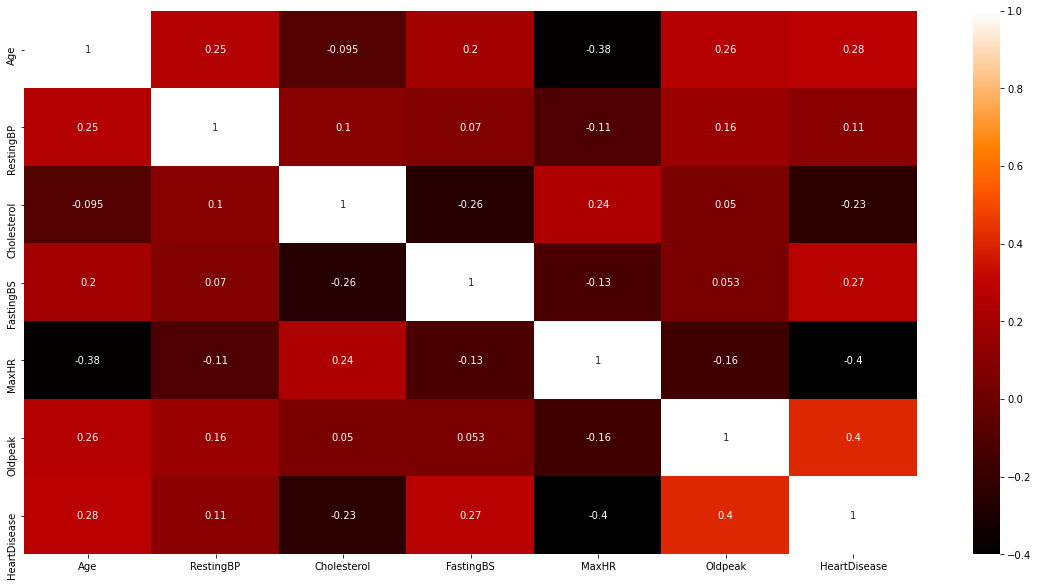

In [12]:
plt.figure(figsize=(20,10))

#plot heat map
sns.heatmap(df.corr(),annot=True,cmap="gist_heat")

In [13]:
#with the function we can select highly correlated  independent features 
#it will remove the first feature that is correlated with anything other feature 
def correlation(df,threshold):
    coll_corr=set() #set of all the names of correlated columns 
    corr_matrix=df.corr()
    for i in range (len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])> threshold:
                colname=corr_matrix.columns[i] #getting the name of columns
                coll_corr.add(colname)
    return coll_corr     

In [14]:
#calling the fuction
corr_feature = correlation(df.iloc[:,:-1],0.85)
len(set(corr_feature))

0

In [15]:
#get numerical and categorical col
#getting the categorical and numerical columns from df
numeric_col=[col for col in df if df[col].dtype !="object" ]
categorical_col=[col for col in df if df[col].dtype=="object" ]
numeric_col.remove("HeartDisease")
print("Numerical col:",numeric_col)
print("Categrical col:",categorical_col)



Numerical col: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
Categrical col: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


In [16]:
df[numeric_col].iplot(kind='histogram',subplots=True)


In [17]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [18]:
fig = px.histogram(df, 'Age',             
                   color="HeartDisease",histfunc="count",
                   title="Age vs HeartDisease")

fig.show()

# 50 to 65 age peoples are suffer in herat disease

In [19]:
fig = px.histogram(df, x='Cholesterol',        
                   color="HeartDisease",
                   title="Cholesterol vsHeartDisease")

fig.show()

In [20]:
fig = px.histogram(df, 'RestingBP',             
                   color="HeartDisease",histfunc="count",
                   title="RestingBP vs HeartDisease")

fig.show()

# Target EDA

In [21]:
pd.DataFrame(df['HeartDisease'].value_counts()).rename({"HeartDisease":"Counts"}, axis = 1).rename_axis("HeartDisease")


,Counts
HeartDisease,
1,508
0,410


In [22]:
fig = px.pie(df, names = "HeartDisease",
             title = "Counts in HeartDisease",
             hole = 0.4, template = "plotly_dark",
            width=600,
            height=400)

fig.update_traces(textposition='inside',
                  textinfo='percent+label',
                  marker=dict(line=dict(color='#000000', width = 2)))


fig.show()


In [23]:
#Sex vs heart disease
df.groupby('Sex')['HeartDisease'].mean().sort_values(ascending=False)*100

Sex
M    63.172414
F    25.906736
Name: HeartDisease, dtype: float64

In [24]:
fig = px.histogram(data_frame = df,
             x = "Sex",
             color="HeartDisease", title="Sex vs HeartDisease",
             pattern_shape_sequence=['x'],template='plotly_dark', width=500,height=300)

fig.show()

In [25]:
#ChestPainType vs Heart disease
df.groupby('ChestPainType')['HeartDisease'].mean().sort_values(ascending=False)*100

ChestPainType
ASY    79.032258
TA     43.478261
NAP    35.467980
ATA    13.872832
Name: HeartDisease, dtype: float64

In [26]:
fig = px.histogram(data_frame = df,
             x = "ChestPainType",
             color="HeartDisease", title="ChestPainType vs HeartDisease",
             pattern_shape_sequence=["x"],template='plotly_dark', width=500,height=300)

fig.show()

# Asymptomatic chest pain has almost 6 times more likely have a heart disease than person with ATA Atypical Angina chest pain

In [27]:
#RestingECG vs HeartDisease
df.groupby('RestingECG')['HeartDisease'].mean().sort_values(ascending=False)*100

RestingECG
ST        65.730337
LVH       56.382979
Normal    51.630435
Name: HeartDisease, dtype: float64

In [28]:
fig = px.histogram(data_frame = df,
             x = "RestingECG",
             color="HeartDisease", title="RestingECG vs HeartDisease",
             pattern_shape_sequence=['x'],template='plotly_dark', width=500,height=300)

fig.show()

# RestingECG: resting electrocardiogram results don't differ much.

In [29]:
#ExerciseAngina vs Heart disease
df.groupby('ExerciseAngina')['HeartDisease'].mean().sort_values(ascending=False)*100

ExerciseAngina
Y    85.175202
N    35.100548
Name: HeartDisease, dtype: float64

In [30]:
fig = px.histogram(data_frame = df,
             x = "ExerciseAngina",
             color="HeartDisease", title="ExerciseAngina vs HeartDisease",
             pattern_shape_sequence=['x'],template='plotly_dark', width=500,height=300)

fig.show()

# exercise-induced angina with 'Yes' almost 2.4 times more likley have a heart disaese than exercise-induced angina with 'No' 😯😯

In [31]:
#ST_Slope vs HeartDisease
df.groupby('ST_Slope')['HeartDisease'].mean().sort_values(ascending=False)*100

ST_Slope
Flat    82.826087
Down    77.777778
Up      19.746835
Name: HeartDisease, dtype: float64

In [32]:
fig = px.histogram(data_frame = df,
             x = "ST_Slope",
             color="HeartDisease", title="ST_Slope vs HeartDisease",
             pattern_shape_sequence=['x'],template='plotly_dark', width=500,height=300)

fig.show()


# ST_Slope Up significantly less likely has heart disease than the other two segment.

# Feature Engineering

In [33]:
# Get the features and terget columns
X=df.iloc[:,0:-1]
y=df.HeartDisease

# Train Test Split

In [34]:
#It is a good practise to split the data to avoiding the data leakage 
#train test split  
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
print("X_train shape: ",x_train.shape)
print("X_test shape: ",x_test.shape)
print("Y_train shape: ",y_train.shape)
print("Y_test shape: ",y_test.shape)

X_train shape:  (642, 11)
X_test shape:  (276, 11)
Y_train shape:  (642,)
Y_test shape:  (276,)


# Normalized skewed col

Columns names:  Index(['Oldpeak'], dtype='object')


skewed value:--->> Oldpeak    1.045232
dtype: float64


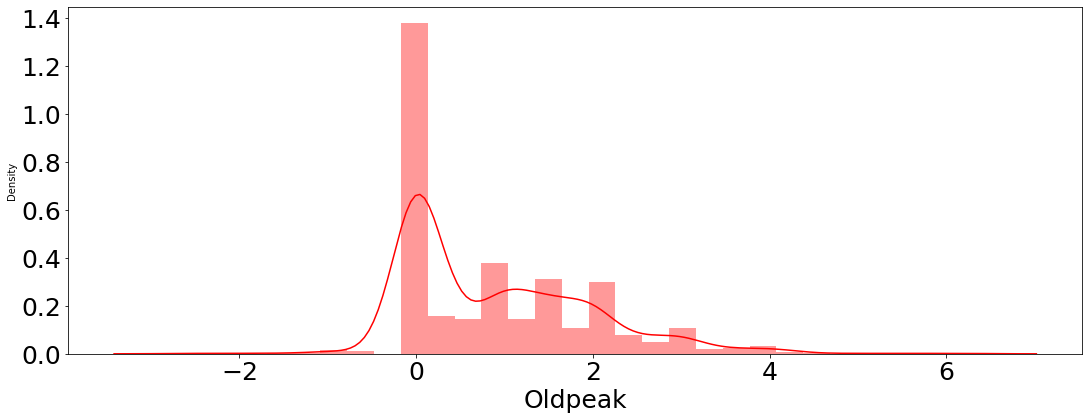

In [35]:
#let find the skewed col and fix them
    
skew_limit=0.75 # limit for skewed col
skew_vals=x_train[numeric_col].drop('FastingBS', axis=1).skew()
skew_col=skew_vals[abs(skew_vals)>skew_limit].sort_values(ascending =False)

#graphically represent the skewed col
i=1    
print("Columns names: ",skew_col.index)
print("\n")
print("skewed value:--->>",skew_col)
plt.figure(figsize=(40,60))
for col in skew_col.index:
    plt.subplot(8,2,i)
    sns.distplot(X[col],color="r")
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlabel(col,fontsize=25)
    i=i+1
        

plt.show()

# we got only 1 skewed columns

In [36]:
#fix the skewness using function transformer
pt=PowerTransformer(standardize=False)
#ft=FunctionTransformer(func=np.log1p)
skew=["Oldpeak"]
x_train[skew]=pt.fit_transform(x_train[skew])
x_test[skew]=pt.transform(x_test[skew])


In [37]:
x_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
712,58,M,ASY,100,234,0,Normal,156,N,0.096924,Up
477,61,M,ASY,110,0,1,Normal,108,Y,1.340771,Down
409,53,M,NAP,160,0,1,LVH,122,Y,0.000000,Flat
448,63,M,ASY,160,230,1,Normal,105,Y,0.784840,Flat
838,63,M,ASY,130,330,1,LVH,132,Y,1.240498,Up


# Encoding the Categorical columns

In [38]:
#Encoding the categorical columns into numerical columns 
x_train=pd.get_dummies(x_train,columns=categorical_col,drop_first=True) #using pandas function
x_test=pd.get_dummies(x_test,columns=categorical_col,drop_first=True)
print("shape:",x_train.shape)
print()
x_train.head()

shape: (642, 15)



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
712,58,100,234,0,156,0.096924,1,0,0,0,1,0,0,0,1
477,61,110,0,1,108,1.340771,1,0,0,0,1,0,1,0,0
409,53,160,0,1,122,0.000000,1,0,1,0,0,0,1,1,0
448,63,160,230,1,105,0.784840,1,0,0,0,1,0,1,1,0
838,63,130,330,1,132,1.240498,1,0,0,0,0,0,1,0,1


In [39]:
# Using standard scaler
sc=StandardScaler()
x_train_scaled=sc.fit_transform(x_train)
x_test_scaled=sc.transform(x_test)

x_train = pd.DataFrame(x_train_scaled, columns = x_train.columns[:])
x_test = pd.DataFrame(x_test_scaled, columns = x_test.columns[:])
x_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,0.464714,-1.772314,0.294989,-0.525682,0.774609,-0.698581,0.544949,-0.489267,-0.520852,-0.209529,0.817027,-0.494152,-0.830346,-1.025241,1.158907
1,0.781767,-1.234868,-1.905390,1.902289,-1.173673,1.037494,0.544949,-0.489267,-0.520852,-0.209529,0.817027,-0.494152,1.204318,-1.025241,-0.862882
2,-0.063707,1.452358,-1.905390,1.902289,-0.605424,-0.833861,0.544949,-0.489267,1.919930,-0.209529,-1.223950,-0.494152,1.204318,0.975381,-0.862882
3,0.993136,1.452358,0.257376,1.902289,-1.295440,0.261564,0.544949,-0.489267,-0.520852,-0.209529,0.817027,-0.494152,1.204318,0.975381,-0.862882
4,0.993136,-0.159978,1.197709,1.902289,-0.199532,0.897540,0.544949,-0.489267,-0.520852,-0.209529,-1.223950,-0.494152,1.204318,-1.025241,1.158907


In [40]:
#this function used to evalute the models with features and terget.
def models_score(models, X_train, X_test, y_train, y_test):    
    
    scores = {}
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred=model.predict(X_test) 
        scores[name] = model.score(X_test,y_test)
        #printing the model name and accuracy !!!!!
        print("Model name: ",model)
        print("Accuracy :--->>",accuracy_score(y_test,y_pred))
        print()
        print(classification_report(y_test,y_pred))
        print("Confusion matrix:--->>\n",confusion_matrix(y_test,y_pred)) 
        print("\n<<<<------------------------------------------------------------->>>>\n")
        
        model_scores = pd.DataFrame(scores, index=['Score']).transpose()
    model_scores = model_scores.sort_values('Score',ascending=False)
    return model_scores

In [41]:
#initialize the models 
models = {"LogisticRegression":LogisticRegression(solver="liblinear"),
          "SVC":SVC(C= 1.0,gamma= 0.05,kernel='rbf'),
          "DecisionTree":DecisionTreeClassifier(criterion='gini',max_depth=5,max_features='auto',splitter='random'),
          "AdaBoost":AdaBoostClassifier(algorithm='SAMME',learning_rate= 0.1,n_estimators=150),
          "GradiantBoost":GradientBoostingClassifier(criterion='friedman_mse',learning_rate=0.05,loss='exponential',n_estimators=100),
         "RandomForest":RandomForestClassifier(criterion='gini',n_estimators=50),
         "XgBoost": XGBClassifier(learning_rate=0.1,n_estimators=50),
         "KNeighborsClassifier":KNeighborsClassifier(n_neighbors=7)}

In [42]:
#Calling the function
model_scores = models_score(models, x_train, x_test, y_train, y_test)

Model name:  LogisticRegression(solver='liblinear')
Accuracy :--->> 0.8731884057971014

              precision    recall  f1-score   support

           0       0.82      0.88      0.85       112
           1       0.92      0.87      0.89       164

    accuracy                           0.87       276
   macro avg       0.87      0.87      0.87       276
weighted avg       0.88      0.87      0.87       276

Confusion matrix:--->>
 [[ 99  13]
 [ 22 142]]

<<<<------------------------------------------------------------->>>>

Model name:  SVC(gamma=0.05)
Accuracy :--->> 0.8876811594202898

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       112
           1       0.91      0.90      0.90       164

    accuracy                           0.89       276
   macro avg       0.88      0.89      0.88       276
weighted avg       0.89      0.89      0.89       276

Confusion matrix:--->>
 [[ 98  14]
 [ 17 147]]

<<<<----------------------

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



Model name:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy :--->> 0.8514492753623188

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       112
           1       0.90      0.84      0.87       164

    accuracy                           0.85       276
   macro avg       0.85      0.85      0.85       276
weighted avg       0.86      0.85      0.85       276

Confusion matrix:--->>
 [[ 97  15]
 [ 26 138]]

<<<

In [43]:
model_scores

,Score
GradiantBoost,0.891304
KNeighborsClassifier,0.891304
SVC,0.887681
LogisticRegression,0.873188
AdaBoost,0.869565
RandomForest,0.862319
XgBoost,0.851449
DecisionTree,0.847826


In [44]:
model_scores = model_scores.reset_index().rename({"index":"Algorithms"}, axis = 1)

model_scores.style.bar()

,Algorithms,Score
0,GradiantBoost,0.891304
1,KNeighborsClassifier,0.891304
2,SVC,0.887681
3,LogisticRegression,0.873188
4,AdaBoost,0.869565
5,RandomForest,0.862319
6,XgBoost,0.851449
7,DecisionTree,0.847826


In [45]:
fig = px.bar(data_frame = model_scores,
             x="Algorithms",
             y="Score",
             color="Algorithms", title = "Models Score", template = 'plotly_dark')

fig.update_layout(bargap=0.2)

fig.show()

In [46]:
label = model_scores['Algorithms']
value = model_scores['Score']

fig = go.Figure(data=[go.Pie(labels = label, values = value, rotation = 90)])

fig.update_traces(textposition='inside',
                  textinfo='percent+label',
                  marker=dict(line=dict(color='#000000', width = 1.5)))

fig.update_layout(title_x=0.5,
                  title_font=dict(size=20),
                  uniformtext_minsize=15)

fig.show()

Confusion matrix:------>>>>



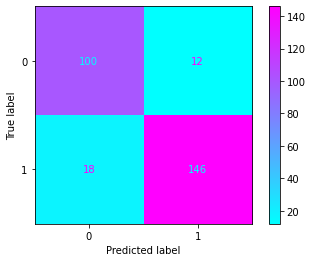

In [47]:
#knn
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train,y_train)
print("Confusion matrix:------>>>>\n")
plot_confusion_matrix(knn,
                      x_test, y_test,
                      cmap="cool",
                      display_labels = ['0', '1'])
plt.grid(False)
plt.show();

Confusion matrix:---------->>>



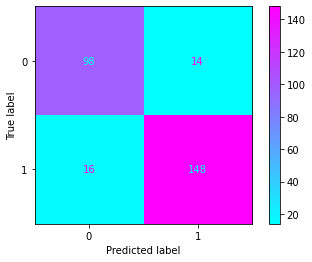

In [48]:
#Gradinat boosting classifier
gbc=GradientBoostingClassifier(criterion='friedman_mse',learning_rate=0.05,loss='exponential',n_estimators=100)
gbc.fit(x_train,y_train)
print("Confusion matrix:---------->>>\n")
plot_confusion_matrix(gbc,
                      x_test, y_test,
                      cmap="cool",
                      display_labels = ['0', '1'])
plt.grid(False)
plt.show();